In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import models, optimizers, layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from IPython.display import display

In [2]:
#read data in
train_data = pd.read_csv('data.csv', header=None)
train_feats, train_labels = train_data.iloc[:, :294], train_data.iloc[:, 294:]

#Normally the data should be splitted into train, validation, and test. For simplicity, only into train and test dataset
train_feats, test_feats, train_labels, test_labels = train_test_split(train_feats, train_labels, test_size=0.2, random_state=88)

train_feats, test_feats = train_feats.reset_index(drop=True), test_feats.reset_index(drop=True)
train_labels, test_labels = train_labels.reset_index(drop=True), test_labels.reset_index(drop=True)

## Explore the data a little bit

In [3]:
print("size of the train and test datasets:")
print("train_feats: ", train_feats.shape, "train_labels: ", train_labels.shape)
print("test_feats: ", test_feats.shape, "test_labels: ", test_labels.shape)

size of the train and test datasets:
train_feats:  (1150, 294) train_labels:  (1150, 6)
test_feats:  (288, 294) test_labels:  (288, 6)


In [4]:
display(train_feats.head())
display(train_labels.head())

,0,1,2,3,4,5,6,7,8,9,...,284,285,286,287,288,289,290,291,292,293
0,0.967815,0.965305,0.967266,0.967333,0.968332,0.962403,0.954184,0.881903,0.907026,0.891654,...,0.090634,0.109361,0.064271,0.103973,0.068763,0.085394,0.038505,0.037156,0.044158,0.032838
1,0.842418,0.893117,0.932735,0.912363,0.877170,0.828890,0.765554,0.827268,0.871978,0.893163,...,0.128894,0.047990,0.019182,0.031557,0.071106,0.115174,0.166455,0.067135,0.075433,0.178611
2,0.660139,0.659172,0.849855,0.943170,0.923969,0.872920,0.801277,0.328766,0.502357,0.605386,...,0.141516,0.002776,0.221038,0.052332,0.084127,0.239873,0.000131,0.257406,0.075757,0.264696
3,0.726324,0.733052,0.737216,0.739765,0.742968,0.744964,0.745442,0.761413,0.766521,0.769302,...,0.212228,0.269081,0.136328,0.014263,0.031924,0.033488,0.039649,0.044403,0.048838,0.045074
4,0.230307,0.316863,0.136670,0.003641,0.194147,0.000000,0.012358,0.409292,0.508322,0.468011,...,0.197179,0.082869,0.005856,0.052804,0.059011,0.048150,0.098081,0.039436,0.140686,0.033844


,294,295,296,297,298,299
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,1,0,0,0,0


In [5]:
#Check how many targets in the train and test datasets have more than one label
sum(train_labels.sum(axis=1)>1)/len(train_labels), sum(test_labels.sum(axis=1)>1)/len(test_labels)

(0.06869565217391305, 0.0763888888888889)

As the purpose is to compare different approaches to deal with multi-label classification, and it seems the split of train and test dataset is reasonable, so no further data exploration is done.

In [6]:
#Global Params
FEATSIZE = 294
BATCHSIZE = 96
EPOCHS = 100

## Initial Test of the model

In [7]:
def accuracy(y_true, y_pred, dim=None):
    if dim is None:
        return sum(np.sum(y_true != y_pred, axis=1) == 0)/len(y_true)
    else:
        return sum(y_true.iloc[:,dim] == y_pred[:,dim])/len(y_true)

In [8]:
def tune_thresold(y_true, y_pred, each_label=False):
    thresh = np.linspace(0.05, 1, 19, False)
    best_acc = 0
    if each_label:
        thresh_dim = 6
        best_thresh = [0]*thresh_dim
        final_pred = y_pred.copy()
    else:
        thresh_dim = 1
        best_thresh = 0
        
    for td in range(thresh_dim):
        if each_label:
            best_acc = 0
            
        for t in thresh:
            if each_label:
                pred = y_pred.copy()
                pred[pred[:, td]>t, td] = 1
                pred[pred[:, td]<=t, td] = 0
                acc = accuracy(y_true, pred, dim=td)
            else:
                pred = y_pred.copy()
                pred[pred>t] = 1
                pred[pred<=t] = 0
                acc = accuracy(y_true, pred)
           
            if acc > best_acc:
                best_acc = acc
                if each_label:
                    final_pred[:,td] = pred[:,td]
                    best_thresh[td] = t
                else:
                    best_thresh = t
                    
    if each_label:
        best_acc = accuracy(y_true, final_pred)
        
    return best_thresh, best_acc

In [9]:
def create_model(loss="categorical_crossentropy", activation='sigmoid', output=6):
    model = models.Sequential()
    model.add(layers.Dense(32, input_shape=(FEATSIZE,),  activation='relu', name="first"))
    model.add(layers.Dense(32, activation='relu', name="second"))
    model.add(layers.Dropout(rate=0.3, name="dropout"))
    model.add(layers.Dense(output, activation=activation, name="output"))

    model.compile(optimizer="adam", loss=loss, metrics=['categorical_accuracy', 'accuracy'])

    return model

In [10]:
#First let's play a little to see which loss function, mean_squared_error vs categorical_crossentropy, is better
mdl = KerasClassifier(build_fn=create_model, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2, verbose=0)
param_grid = {"loss": ['binary_crossentropy', 'mean_squared_error']}
grid = GridSearchCV(estimator=mdl, param_grid=param_grid)
grid_result = grid.fit(train_feats, train_labels)
# summarize results
print("Best: {:.4f} using {}".format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("{:.4f} ({:.4f}) with: {}".format(mean, stdev, param))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


c:\python\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Instructions for updating:
Use tf.cast instead.
Best: 0.9051 using {'loss': 'binary_crossentropy'}
0.9051 (0.0026) with: {'loss': 'binary_crossentropy'}
0.7270 (0.0099) with: {'loss': 'mean_squared_error'}


(NOTE: this does not entirely suitable for multi-label classification as the accuracy here is based on assumption that each target has only one non-zero label. Nevertheless, the dataset does not have many targets that have more than one non-zero label)

In [11]:
grid.best_estimator_.predict(test_feats)[:5], grid.best_estimator_.predict_proba(test_feats)[:5]

(array([3, 2, 3, 4, 2]),
 array([[4.3563247e-03, 9.2607439e-03, 3.2066792e-02, 8.5231483e-01,
         1.7571998e-01, 2.8425157e-03],
        [3.4976006e-04, 1.4197826e-04, 9.9604321e-01, 1.7736554e-03,
         1.0573566e-03, 6.4209998e-03],
        [3.8129687e-03, 2.8848648e-05, 5.8147311e-04, 9.7495776e-01,
         1.4616874e-01, 1.5932322e-04],
        [2.7246317e-01, 2.6810169e-04, 3.8206577e-05, 6.2488616e-03,
         7.1350735e-01, 7.2612226e-02],
        [3.0350685e-04, 4.5818090e-04, 9.9582219e-01, 4.5439601e-04,
         4.7713518e-05, 5.9962273e-05]], dtype=float32))

In [12]:
preds = grid.best_estimator_.predict_proba(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [13]:
#Accuracy on the test dataset, and number of estimates that have more than one non-zero label
print('Test accuracy: {:.4f}, Percentage with more than one non-zero label: {:.2f}%' \
       .format(accuracy(test_labels, preds), sum(preds.sum(axis=1)>1)/len(test_labels)*100))

Test accuracy: 0.6493, Percentage with more than one non-zero label: 2.08%


## Method 1: Neural Network using Sigmoid activation

In [14]:
mdl1 = create_model(loss="binary_crossentropy", activation="sigmoid")
mdl1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = mdl1.fit(train_feats, train_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples
Epoch 1/100
920/920 [==============================] - 0s 413us/sample - loss: 0.6469 - categorical_accuracy: 0.1859 - acc: 0.6400 - val_loss: 0.5534 - val_categorical_accuracy: 0.2000 - val_acc: 0.7790
Epoch 2/100
920/920 [==============================] - 0s 55us/sample - loss: 0.5446 - categorical_accuracy: 0.2141 - acc: 0.7611 - val_loss: 0.4834 - val_categorical_accuracy: 0.2000 - val_acc: 0.8225
Epoch 3/100
920/920 [==============================] - 0s 55us/sample - loss: 0.5027 - categorical_accuracy: 0.2163 - acc: 0.7989 - val_loss: 0.4516 - val_categorical_accuracy: 0.3217 - val_acc: 0.8225
Epoch 4/100
920/920 [==============================] - 0s 51us/sample - loss: 0.4779 - categorical_accuracy: 0.2576 - acc: 0.8116 - val_loss: 0.4340 - val_categorical_accuracy: 0.4130 - val_acc: 0.8225
Epoch 5/100
920/920 [==============================] - 0s 50us/sample - loss: 0.4618 - categorical_accuracy: 0.3120 - acc: 0.8167 - val_loss: 0.4

920/920 [==============================] - 0s 49us/sample - loss: 0.2359 - categorical_accuracy: 0.7239 - acc: 0.8969 - val_loss: 0.2215 - val_categorical_accuracy: 0.7304 - val_acc: 0.9072
Epoch 42/100
920/920 [==============================] - 0s 46us/sample - loss: 0.2290 - categorical_accuracy: 0.7424 - acc: 0.9013 - val_loss: 0.2197 - val_categorical_accuracy: 0.7435 - val_acc: 0.9087
Epoch 43/100
920/920 [==============================] - 0s 41us/sample - loss: 0.2273 - categorical_accuracy: 0.7500 - acc: 0.9027 - val_loss: 0.2189 - val_categorical_accuracy: 0.7435 - val_acc: 0.9072
Epoch 44/100
920/920 [==============================] - 0s 43us/sample - loss: 0.2296 - categorical_accuracy: 0.7250 - acc: 0.9029 - val_loss: 0.2177 - val_categorical_accuracy: 0.7435 - val_acc: 0.9094
Epoch 45/100
920/920 [==============================] - 0s 42us/sample - loss: 0.2210 - categorical_accuracy: 0.7380 - acc: 0.9083 - val_loss: 0.2153 - val_categorical_accuracy: 0.7435 - val_acc: 0.908

920/920 [==============================] - 0s 42us/sample - loss: 0.1725 - categorical_accuracy: 0.8217 - acc: 0.9324 - val_loss: 0.1935 - val_categorical_accuracy: 0.8043 - val_acc: 0.9246
Epoch 82/100
920/920 [==============================] - 0s 42us/sample - loss: 0.1689 - categorical_accuracy: 0.8217 - acc: 0.9288 - val_loss: 0.1931 - val_categorical_accuracy: 0.7913 - val_acc: 0.9181
Epoch 83/100
920/920 [==============================] - 0s 42us/sample - loss: 0.1615 - categorical_accuracy: 0.8207 - acc: 0.9362 - val_loss: 0.1932 - val_categorical_accuracy: 0.8087 - val_acc: 0.9232
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.1657 - categorical_accuracy: 0.8283 - acc: 0.9341 - val_loss: 0.1933 - val_categorical_accuracy: 0.7870 - val_acc: 0.9181
Epoch 85/100
920/920 [==============================] - 0s 43us/sample - loss: 0.1636 - categorical_accuracy: 0.8283 - acc: 0.9324 - val_loss: 0.1909 - val_categorical_accuracy: 0.7957 - val_acc: 0.921

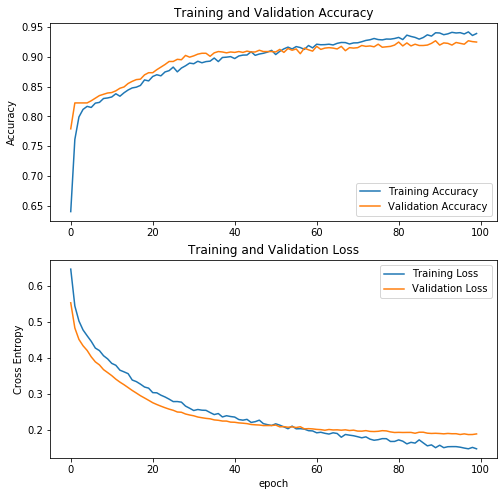

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
test_preds = mdl1.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [18]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6562
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0455


### Tune the threshold and see if the performance is improved

In [19]:
train_preds = mdl1.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.7713 for best_threshold: 0.44999999999999996


In [20]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6632
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.1818


### Tune the threshold for each label and see if the performance is improved

In [21]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.7791 for best_threshold: [0.35, 0.25, 0.3, 0.39999999999999997, 0.49999999999999994, 0.44999999999999996]


In [22]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6597
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0909


## Method 2: Neural Network using Softmax activation

In [23]:
mdl2 = create_model(activation='softmax')
mdl2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [24]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
history = mdl2.fit(train_feats, train_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples


Using TensorFlow backend.


Epoch 1/100
920/920 [==============================] - 0s 378us/sample - loss: 1.8917 - categorical_accuracy: 0.2359 - acc: 0.2359 - val_loss: 1.8037 - val_categorical_accuracy: 0.3565 - val_acc: 0.3565
Epoch 2/100
920/920 [==============================] - 0s 42us/sample - loss: 1.7816 - categorical_accuracy: 0.3043 - acc: 0.3043 - val_loss: 1.6919 - val_categorical_accuracy: 0.4913 - val_acc: 0.4913
Epoch 3/100
920/920 [==============================] - 0s 42us/sample - loss: 1.6731 - categorical_accuracy: 0.4054 - acc: 0.4054 - val_loss: 1.5609 - val_categorical_accuracy: 0.6000 - val_acc: 0.6000
Epoch 4/100
920/920 [==============================] - 0s 46us/sample - loss: 1.5744 - categorical_accuracy: 0.4783 - acc: 0.4783 - val_loss: 1.4515 - val_categorical_accuracy: 0.5913 - val_acc: 0.5913
Epoch 5/100
920/920 [==============================] - 0s 44us/sample - loss: 1.4610 - categorical_accuracy: 0.5033 - acc: 0.5033 - val_loss: 1.3518 - val_categorical_accuracy: 0.6217 - val_a

920/920 [==============================] - 0s 44us/sample - loss: 0.7599 - categorical_accuracy: 0.7696 - acc: 0.7696 - val_loss: 0.7738 - val_categorical_accuracy: 0.7652 - val_acc: 0.7652
Epoch 42/100
920/920 [==============================] - 0s 43us/sample - loss: 0.7468 - categorical_accuracy: 0.7565 - acc: 0.7565 - val_loss: 0.7768 - val_categorical_accuracy: 0.7304 - val_acc: 0.7304
Epoch 43/100
920/920 [==============================] - 0s 42us/sample - loss: 0.7208 - categorical_accuracy: 0.7967 - acc: 0.7967 - val_loss: 0.7759 - val_categorical_accuracy: 0.7391 - val_acc: 0.7391
Epoch 44/100
920/920 [==============================] - 0s 43us/sample - loss: 0.7235 - categorical_accuracy: 0.7696 - acc: 0.7696 - val_loss: 0.7652 - val_categorical_accuracy: 0.7565 - val_acc: 0.7565
Epoch 45/100
920/920 [==============================] - 0s 42us/sample - loss: 0.7201 - categorical_accuracy: 0.7902 - acc: 0.7902 - val_loss: 0.7736 - val_categorical_accuracy: 0.7522 - val_acc: 0.752

920/920 [==============================] - 0s 42us/sample - loss: 0.5629 - categorical_accuracy: 0.8380 - acc: 0.8380 - val_loss: 0.7590 - val_categorical_accuracy: 0.7435 - val_acc: 0.7435
Epoch 82/100
920/920 [==============================] - 0s 41us/sample - loss: 0.5467 - categorical_accuracy: 0.8446 - acc: 0.8446 - val_loss: 0.7688 - val_categorical_accuracy: 0.7609 - val_acc: 0.7609
Epoch 83/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5654 - categorical_accuracy: 0.8261 - acc: 0.8261 - val_loss: 0.7561 - val_categorical_accuracy: 0.7652 - val_acc: 0.7652
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.5540 - categorical_accuracy: 0.8380 - acc: 0.8380 - val_loss: 0.7600 - val_categorical_accuracy: 0.7522 - val_acc: 0.7522
Epoch 85/100
920/920 [==============================] - 0s 41us/sample - loss: 0.5526 - categorical_accuracy: 0.8348 - acc: 0.8348 - val_loss: 0.7650 - val_categorical_accuracy: 0.7478 - val_acc: 0.747

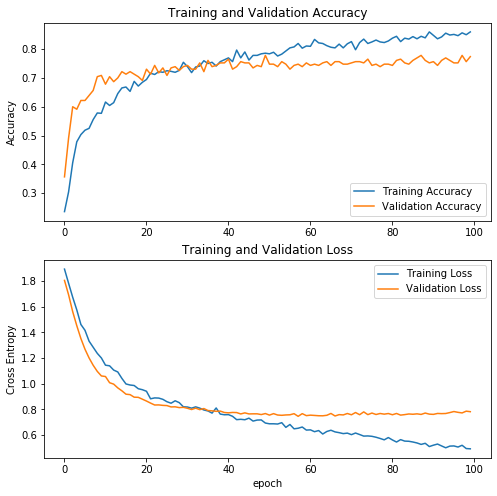

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
test_preds = mdl2.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [27]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6736
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [28]:
train_preds = mdl2.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8165 for best_threshold: 0.39999999999999997


In [29]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6771
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0455


### Tune the threshold for each label and see if the performance is improved

In [30]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8270 for best_threshold: [0.49999999999999994, 0.65, 0.44999999999999996, 0.35, 0.49999999999999994, 0.3]


In [31]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6979
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


## Method 3: Expand the samples with multiple non-zero label into multiple samples with single non-zero label and using Neural Network

In [32]:
def expand_samples(feats, labels):
    #index to sample with more than 1 non-zero sample and otherwise
    idx1 = labels.sum(axis=1)<=1
    idx2 = labels[labels.sum(axis=1)>1].index
    
    new_feats = feats[idx1].copy()
    new_labels = labels[idx1].copy()
    
    for idx in idx2:
        label = labels.iloc[idx,:]
        feat = feats.iloc[idx,:]
        for label_pos in np.where(label)[0]:
            new_label = [0]*6
            new_label[label_pos] = 1
            new_feats = new_feats.append(feat, ignore_index=True)
            new_labels = new_labels.append(pd.DataFrame([new_label], columns=labels.columns), ignore_index=True)
            
    return new_feats, new_labels

In [33]:
new_feats, new_labels = expand_samples(train_feats, train_labels)

In [34]:
mdl3 = create_model(activation='softmax')
mdl3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 6)                 198       
Total params: 10,694
Trainable params: 10,694
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = mdl3.fit(new_feats, new_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 983 samples, validate on 246 samples
Epoch 1/100
983/983 [==============================] - 0s 345us/sample - loss: 1.7519 - categorical_accuracy: 0.2330 - acc: 0.2330 - val_loss: 1.7479 - val_categorical_accuracy: 0.2683 - val_acc: 0.2683
Epoch 2/100
983/983 [==============================] - 0s 44us/sample - loss: 1.6569 - categorical_accuracy: 0.3062 - acc: 0.3062 - val_loss: 1.6943 - val_categorical_accuracy: 0.3455 - val_acc: 0.3455
Epoch 3/100
983/983 [==============================] - 0s 44us/sample - loss: 1.5651 - categorical_accuracy: 0.3805 - acc: 0.3805 - val_loss: 1.6193 - val_categorical_accuracy: 0.3659 - val_acc: 0.3659
Epoch 4/100
983/983 [==============================] - 0s 45us/sample - loss: 1.4808 - categorical_accuracy: 0.4222 - acc: 0.4222 - val_loss: 1.5835 - val_categorical_accuracy: 0.3659 - val_acc: 0.3659
Epoch 5/100
983/983 [==============================] - 0s 45us/sample - loss: 1.4004 - categorical_accuracy: 0.4273 - acc: 0.4273 - val_loss: 1.5

983/983 [==============================] - 0s 46us/sample - loss: 0.5865 - categorical_accuracy: 0.7864 - acc: 0.7864 - val_loss: 1.2850 - val_categorical_accuracy: 0.5772 - val_acc: 0.5772
Epoch 42/100
983/983 [==============================] - 0s 44us/sample - loss: 0.5910 - categorical_accuracy: 0.7782 - acc: 0.7782 - val_loss: 1.2939 - val_categorical_accuracy: 0.5772 - val_acc: 0.5772
Epoch 43/100
983/983 [==============================] - 0s 42us/sample - loss: 0.5584 - categorical_accuracy: 0.7843 - acc: 0.7843 - val_loss: 1.3299 - val_categorical_accuracy: 0.5813 - val_acc: 0.5813
Epoch 44/100
983/983 [==============================] - 0s 44us/sample - loss: 0.5769 - categorical_accuracy: 0.7792 - acc: 0.7792 - val_loss: 1.3400 - val_categorical_accuracy: 0.5854 - val_acc: 0.5854
Epoch 45/100
983/983 [==============================] - 0s 42us/sample - loss: 0.5462 - categorical_accuracy: 0.7976 - acc: 0.7976 - val_loss: 1.3109 - val_categorical_accuracy: 0.5854 - val_acc: 0.585

983/983 [==============================] - 0s 44us/sample - loss: 0.4286 - categorical_accuracy: 0.8403 - acc: 0.8403 - val_loss: 1.4815 - val_categorical_accuracy: 0.5813 - val_acc: 0.5813
Epoch 82/100
983/983 [==============================] - 0s 45us/sample - loss: 0.3900 - categorical_accuracy: 0.8637 - acc: 0.8637 - val_loss: 1.4984 - val_categorical_accuracy: 0.5691 - val_acc: 0.5691
Epoch 83/100
983/983 [==============================] - 0s 43us/sample - loss: 0.4009 - categorical_accuracy: 0.8606 - acc: 0.8606 - val_loss: 1.5198 - val_categorical_accuracy: 0.5894 - val_acc: 0.5894
Epoch 84/100
983/983 [==============================] - 0s 42us/sample - loss: 0.4055 - categorical_accuracy: 0.8474 - acc: 0.8474 - val_loss: 1.5058 - val_categorical_accuracy: 0.5732 - val_acc: 0.5732
Epoch 85/100
983/983 [==============================] - 0s 42us/sample - loss: 0.3889 - categorical_accuracy: 0.8627 - acc: 0.8627 - val_loss: 1.4691 - val_categorical_accuracy: 0.5528 - val_acc: 0.552

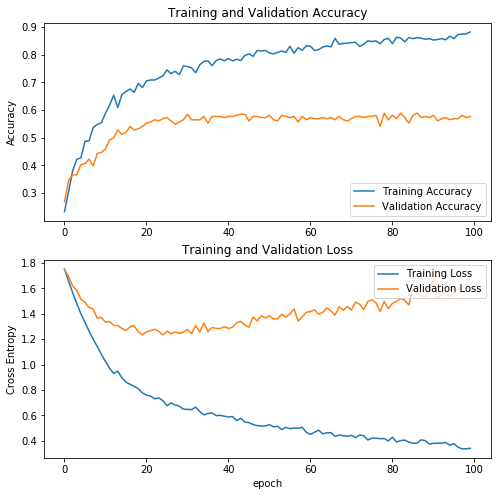

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
test_preds = mdl3.predict(test_feats)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [38]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6771
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [39]:
train_preds = mdl3.predict(train_feats)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8330 for best_threshold: 0.44999999999999996


In [40]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6701
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold for each label and see if the performance is improved

In [41]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8357 for best_threshold: [0.39999999999999997, 0.35, 0.39999999999999997, 0.3, 0.35, 0.49999999999999994]


In [42]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6910
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


## Method 4: Neural Network using Fake Tags and Softmax activation

In [43]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [44]:
label_encoder = LabelEncoder()

In [45]:
def encode_multi_tag(labels):
    new_labels = []
    for l in labels.values:
        new_labels.append(','.join(map(str, l)))
    new_labels = label_encoder.fit_transform(new_labels)
    new_labels = to_categorical(new_labels)
    return new_labels

(NOTE: it is verified that train dataset has all the occurrence of different tag combinations seen in the test dataset)

In [46]:
new_labels = encode_multi_tag(train_labels)

In [47]:
mdl4 = create_model(activation='softmax', output=12)
mdl4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 32)                9440      
_________________________________________________________________
second (Dense)               (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
output (Dense)               (None, 12)                396       
Total params: 10,892
Trainable params: 10,892
Non-trainable params: 0
_________________________________________________________________


In [49]:
history = mdl4.fit(train_feats, new_labels, epochs=EPOCHS, batch_size=BATCHSIZE, validation_split=0.2)

Train on 920 samples, validate on 230 samples
Epoch 1/100
920/920 [==============================] - 0s 398us/sample - loss: 2.4046 - categorical_accuracy: 0.1293 - acc: 0.1293 - val_loss: 2.2145 - val_categorical_accuracy: 0.1696 - val_acc: 0.1696
Epoch 2/100
920/920 [==============================] - 0s 50us/sample - loss: 2.2230 - categorical_accuracy: 0.1565 - acc: 0.1565 - val_loss: 2.0654 - val_categorical_accuracy: 0.1957 - val_acc: 0.1957
Epoch 3/100
920/920 [==============================] - 0s 48us/sample - loss: 2.1131 - categorical_accuracy: 0.1967 - acc: 0.1967 - val_loss: 1.9482 - val_categorical_accuracy: 0.2565 - val_acc: 0.2565
Epoch 4/100
920/920 [==============================] - 0s 46us/sample - loss: 2.0143 - categorical_accuracy: 0.2511 - acc: 0.2511 - val_loss: 1.8698 - val_categorical_accuracy: 0.3478 - val_acc: 0.3478
Epoch 5/100
920/920 [==============================] - 0s 44us/sample - loss: 1.9248 - categorical_accuracy: 0.3272 - acc: 0.3272 - val_loss: 1.7

920/920 [==============================] - 0s 42us/sample - loss: 0.9258 - categorical_accuracy: 0.7087 - acc: 0.7087 - val_loss: 0.9059 - val_categorical_accuracy: 0.7043 - val_acc: 0.7043
Epoch 41/100
920/920 [==============================] - 0s 47us/sample - loss: 0.8948 - categorical_accuracy: 0.6989 - acc: 0.6989 - val_loss: 0.9205 - val_categorical_accuracy: 0.6609 - val_acc: 0.6609
Epoch 42/100
920/920 [==============================] - 0s 53us/sample - loss: 0.9158 - categorical_accuracy: 0.7011 - acc: 0.7011 - val_loss: 0.9039 - val_categorical_accuracy: 0.6870 - val_acc: 0.6870
Epoch 43/100
920/920 [==============================] - 0s 52us/sample - loss: 0.9166 - categorical_accuracy: 0.6848 - acc: 0.6848 - val_loss: 0.8936 - val_categorical_accuracy: 0.6870 - val_acc: 0.6870
Epoch 44/100
920/920 [==============================] - ETA: 0s - loss: 0.7780 - categorical_accuracy: 0.8021 - acc: 0.80 - 0s 52us/sample - loss: 0.9121 - categorical_accuracy: 0.7000 - acc: 0.7000 - 

920/920 [==============================] - 0s 42us/sample - loss: 0.7174 - categorical_accuracy: 0.7663 - acc: 0.7663 - val_loss: 0.8492 - val_categorical_accuracy: 0.7000 - val_acc: 0.7000
Epoch 81/100
920/920 [==============================] - 0s 44us/sample - loss: 0.6567 - categorical_accuracy: 0.7815 - acc: 0.7815 - val_loss: 0.8215 - val_categorical_accuracy: 0.7000 - val_acc: 0.7000
Epoch 82/100
920/920 [==============================] - 0s 42us/sample - loss: 0.6574 - categorical_accuracy: 0.7902 - acc: 0.7902 - val_loss: 0.8089 - val_categorical_accuracy: 0.7000 - val_acc: 0.7000
Epoch 83/100
920/920 [==============================] - 0s 41us/sample - loss: 0.6844 - categorical_accuracy: 0.7685 - acc: 0.7685 - val_loss: 0.8168 - val_categorical_accuracy: 0.7174 - val_acc: 0.7174
Epoch 84/100
920/920 [==============================] - 0s 42us/sample - loss: 0.6852 - categorical_accuracy: 0.7815 - acc: 0.7815 - val_loss: 0.8125 - val_categorical_accuracy: 0.7000 - val_acc: 0.700

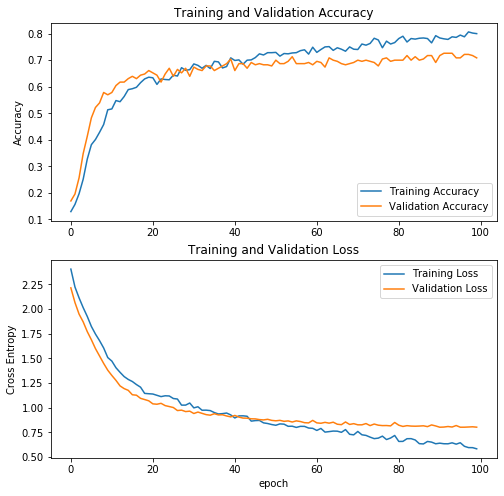

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [51]:
def assign_prob_to_tags(preds):
    pred_class = np.argmax(preds, axis=1)
    orig_labels = label_encoder.inverse_transform(pred_class)
    probs = []
    for i in range(len(orig_labels)):
        ol = np.array(list(map(int, orig_labels[i].split(','))), dtype=np.float16)
        ol[ol==1] = preds[i, pred_class[i]]
        probs.append(ol)
   
    return np.array(probs)

In [52]:
test_preds = mdl4.predict(test_feats)
test_preds = assign_prob_to_tags(test_preds)
#assume the default threshold is 0.5; could be tuned later
preds = test_preds.copy()
preds[preds>0.5] = 1
preds[preds<=0.5] = 0
preds[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float16)

In [53]:
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6319
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold and see if the performance is improved

In [54]:
train_preds = mdl4.predict(train_feats)
train_preds = assign_prob_to_tags(train_preds)
thresh, acc = tune_thresold(train_labels, train_preds)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8183 for best_threshold: 0.05


In [55]:
preds = test_preds.copy()
preds[preds>thresh] = 1
preds[preds<=thresh] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.7083
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


### Tune the threshold for each label and see if the performance is improved

In [56]:
thresh, acc = tune_thresold(train_labels, train_preds, each_label=True)
print('best_acc: {:.4f} for best_threshold: {}'.format(acc, thresh))

best_acc: 0.8122 for best_threshold: [0.35, 0.6, 0.35, 0.35, 0.05, 0.44999999999999996]


In [57]:
preds = test_preds.copy()
for td in range(6):
    preds[preds[:,td]>thresh[td], td] = 1
    preds[preds[:,td]<=thresh[td], td] = 0
print('Accuracy of method 1 on the test dataset: {:.4f}'.format(accuracy(test_labels, preds)))
idx = test_labels.sum(axis=1) > 1
print('Accuracy of method 1 on the test dataset with more than one non-zero label: {:.4f}'.format(accuracy(test_labels[idx], preds[idx])))

Accuracy of method 1 on the test dataset: 0.6979
Accuracy of method 1 on the test dataset with more than one non-zero label: 0.0000


#### The data used in this test is very small, therefore, no conclusive statements could be made. Instead the practice is to explore and preliminarily compare the different methods to deal with multi-label classification problem. Based on this very preliminary test, it seems some methods (e.g. method 1) may not be able to predict correctly for the sample with more than one non-zero label, while other methods cannot. Nevertheless, tuning the threshold based on the training data indeed increase the predict accuracy on the test dataset.